# Portfolio Generation

This notebook uses the top funds from the previous notebooks to prepare a portfolio allocation.

Note: This notebook assumes that you have loaded data within the `data/portfolios.json` and `data/pricing` by running the `init.py`. It also assumes that you've run all the notebooks with prior numbering.


In [382]:
# Lib imports.
import pandas as pd

pd.set_option("expand_frame_repr", False)
import os
import numpy as np
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier
import matplotlib.pyplot as plt
from typing import Tuple, List, Callable

In [383]:
# Constants
DATA_PATH = "data/output/complete_top_ranking.csv"
if not os.path.exists(DATA_PATH):
    raise ValueError(
        "Missing file", DATA_PATH, "generate it using the previous notebook."
    )

# Columns.
COLUMN_DATE = "asOfDate"
COLUMN_PRICE = "price"

## Loading & Ranking

We start by loading all the data.


In [384]:
complete_top_ranking = pd.read_csv(DATA_PATH, header=0, index_col=0)
sp_index = [
    i
    for i in range(complete_top_ranking.shape[1])
    if "S&P 500" in complete_top_ranking.columns[i]
]

print(f"Loaded {complete_top_ranking.shape} rows.")
print(f"S&P 500 is index {sp_index} in {complete_top_ranking.columns}")

Loaded (493, 30) rows.
S&P 500 is index [25] in Index(['ESG Developed Europe All Cap UCITS ETF (Accumulation)',
       'ESG Developed World All Cap Equity Index Fund (Accumulation)',
       'ESG Developed World All Cap Equity Index Fund (UK) (Accumulation)',
       'ESG EUR Corporate Bond UCITS ETF (Hedged Accumulation)',
       'ESG Emerging Markets All Cap UCITS ETF (Accumulation)',
       'ESG Global All Cap UCITS ETF (Accumulation)',
       'ESG Global Corporate Bond UCITS ETF (Hedged Accumulation)',
       'ESG North America All Cap UCITS ETF (Accumulation)',
       'EUR Corporate Bond UCITS ETF (Accumulation)',
       'Emerging Markets Bond Fund (Hedged Accumulation)',
       'Euro Investment Grade Bond Index Fund (Hedged Accumulation)',
       'FTSE All-World High Dividend Yield UCITS ETF (Accumulation)',
       'FTSE All-World UCITS ETF (Accumulation)',
       'FTSE Developed Europe UCITS ETF (Accumulation)',
       'FTSE Developed Europe ex UK UCITS ETF (Accumulation)',
      

We can generate an efficient frontier using these datapoints.


In [385]:
mu = mean_historical_return(complete_top_ranking)
cov = CovarianceShrinkage(complete_top_ranking).ledoit_wolf()

/Users/gonzalo/repository/python-fund-trading-bots/.env/lib/python3.11/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")
/Users/gonzalo/repository/python-fund-trading-bots/.env/lib/python3.11/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")


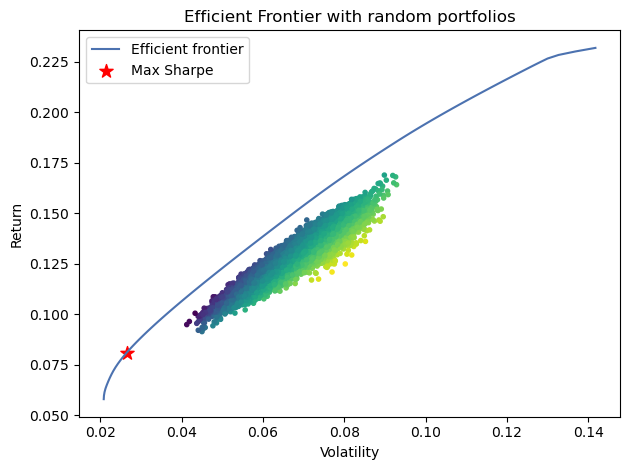

In [386]:
sp_constraint = lambda x: x[sp_index] >= 10.0
ef_base, ef = EfficientFrontier(mu, cov), EfficientFrontier(mu, cov)
# ef_base.add_constraint(sp_constraint)
# ef.add_constraint(sp_constraint)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_base, ax=ax, show_assets=False)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 20000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ cov @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

Preparing an asset allocation based on the EF. This is using a MAX SHARPE but setting a constraint in terms of the allocation of S&P.


Maximum gradient at return 0.14773534414711142 with allocation 0.45


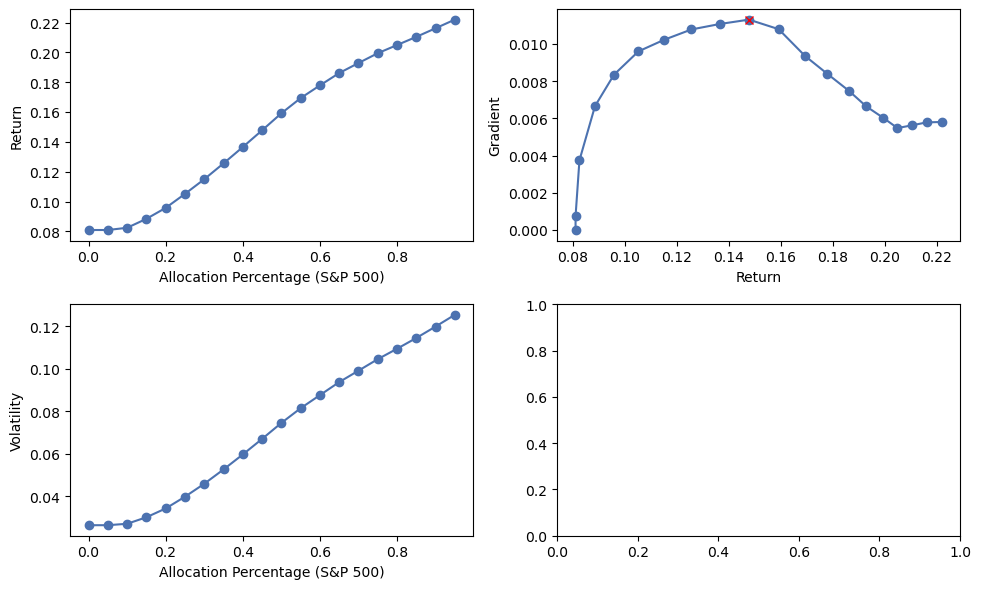

In [387]:
fig_sbs, axes_sbs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

x, y, risk, point = [], [], [], []
sp_allocations = np.arange(0, 1, 0.05)
for alloc in sp_allocations:
    ef_restricted = EfficientFrontier(mu, cov)
    ef_restricted.add_constraint(lambda x: x[sp_index] >= alloc)
    weights = ef_restricted.max_sharpe()
    _return, _volatility, _ = ef_restricted.portfolio_performance(verbose=False)
    x.append(alloc)
    y.append(_return)
    risk.append(_volatility)
    point.append(alloc)

axes_sbs[0][0].set_xlabel("Allocation Percentage (S&P 500)")
axes_sbs[0][0].set_ylabel("Return")
axes_sbs[0][0].plot(x, y, linestyle="-", marker="o")

axes_sbs[1][0].set_xlabel("Allocation Percentage (S&P 500)")
axes_sbs[1][0].set_ylabel("Volatility")
axes_sbs[1][0].plot(x, risk, linestyle="-", marker="o")

axes_sbs[0][1].set_xlabel("Return")
axes_sbs[0][1].set_ylabel("Gradient")
axes_sbs[0][1].plot(y, np.gradient(y), linestyle="-", marker="o")
index_max = np.argmax(np.gradient(y))
axes_sbs[0][1].plot(
    [y[index_max]], [np.gradient(y)[index_max]], marker="x", color="red"
)
fig_sbs.tight_layout()
print(
    f"Maximum gradient at return {y[index_max]} with allocation {sp_allocations[index_max]}"
)

We can try to explore different scenarios and different constraints.

In [388]:
bond_id_set = set(
    index
    for index, col in enumerate(complete_top_ranking.columns)
    if "bond" in str(col).lower()
)
etf_id_set = set(
    index
    for index, col in enumerate(complete_top_ranking.columns)
    if "etf" in str(col).lower()
)
ucits_id_set = set(
    index
    for index, col in enumerate(complete_top_ranking.columns)
    if "ucits" in str(col).lower()
)
print("IDs of ETF funds", bond_id_set)
print("IDs of BOND funds", etf_id_set)
print("IDs of UCITS funds", ucits_id_set)

IDs of ETF funds {3, 6, 8, 9, 10, 20, 21, 22, 27, 28, 29}
IDs of BOND funds {0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 17, 18, 19, 25, 27, 28, 29}
IDs of UCITS funds {0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 17, 18, 19, 25, 27, 28, 29}


We can generate basic constraints we can reuse.

In [389]:
bond_lt_constraint = (
    lambda x, val: sum([w if index in bond_id_set else 0 for index, w in enumerate(x)])
    <= val
)
etf_lt_constraint = (
    lambda x, val: sum([w if index in etf_id_set else 0 for index, w in enumerate(x)])
    <= val
)
ucits_lt_constraint = (
    lambda x, val: sum([w if index in ucits_id_set else 0 for index, w in enumerate(x)])
    <= val
)
sp_gt_constraint = lambda x, val: x[sp_index] >= val
sp_lt_constraint = lambda x, val: x[sp_index] <= val


def run_constraints(
    constraint: Callable, values: List[float], target_return: float, mu, cov, is_risk:bool = True
) -> Tuple[np.array, np.array]:
    y = []
    for val in values:
        try:
            ef = EfficientFrontier(mu, cov)
            ef.add_constraint(lambda x: constraint(x, val))
            if is_risk:
                ef.efficient_return(target_return=target_return)
            else:
                ef.max_sharpe()
            _return, _volatility, _ = ef.portfolio_performance(verbose=False)
            output_value = _volatility if is_risk else _return
        except Exception:
            output_value = -1
        y.append(output_value)
    return values, y

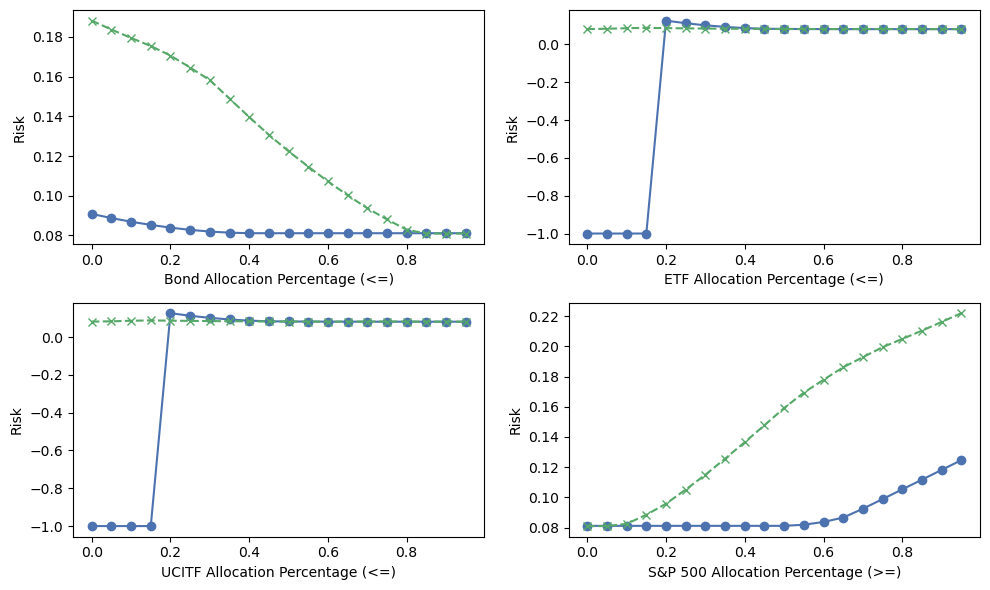

In [390]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Holds all the potential allocations
allocations = np.arange(0, 1, 0.05)
expected_return = 0.17

axes[0][0].set_xlabel("Bond Allocation Percentage (<=)")
axes[0][0].set_ylabel("Risk")
axes[0][0].plot(
    *run_constraints(
        bond_lt_constraint,
        allocations,
        target_return=expected_return,
        mu=mu,
        cov=cov,
    ),
    linestyle="-",
    marker="o",
)
axes[0][0].plot(
    *run_constraints(
        bond_lt_constraint,
        allocations,
        target_return=expected_return,
        mu=mu,
        cov=cov,
        is_risk=False
    ),
    linestyle="--",
    marker="x",
)

axes[0][1].set_xlabel("ETF Allocation Percentage (<=)")
axes[0][1].set_ylabel("Risk")
axes[0][1].plot(
    *run_constraints(
        etf_lt_constraint,
        allocations,
        target_return=expected_return,
        mu=mu,
        cov=cov,
    ),
    linestyle="-",
    marker="o",
)
axes[0][1].plot(
    *run_constraints(
        etf_lt_constraint,
        allocations,
        target_return=expected_return,
        mu=mu,
        cov=cov,
        is_risk=False,
    ),
    linestyle="--",
    marker="x",
)

axes[1][0].set_xlabel("UCITF Allocation Percentage (<=)")
axes[1][0].set_ylabel("Risk")
axes[1][0].plot(
    *run_constraints(
        ucits_lt_constraint,
        allocations,
        target_return=expected_return,
        mu=mu,
        cov=cov,
    ),
    linestyle="-",
    marker="o",
)
axes[1][0].plot(
    *run_constraints(
        ucits_lt_constraint,
        allocations,
        target_return=expected_return,
        mu=mu,
        cov=cov,
        is_risk=False,
    ),
    linestyle="--",
    marker="x",
)

axes[1][1].set_xlabel("S&P 500 Allocation Percentage (>=)")
axes[1][1].set_ylabel("Risk")
axes[1][1].plot(
    *run_constraints(
        sp_gt_constraint,
        allocations,
        target_return=expected_return,
        mu=mu,
        cov=cov,
    ),
    linestyle="-",
    marker="o",
)
axes[1][1].plot(
    *run_constraints(
        sp_gt_constraint,
        allocations,
        target_return=expected_return,
        mu=mu,
        cov=cov,
        is_risk=False,
    ),
    linestyle="--",
    marker="x",
)

fig.tight_layout()

In [ ]:
portfolio_amount = 8100

# Create model.
ef = EfficientFrontier(mu, cov)

# Add all constraints.
ef.add_constraint(lambda x: sp_lt_constraint(x, 0.7))
ef.add_constraint(lambda x: bond_lt_constraint(x, 0.2))

# Apply target
ef.efficient_return(target_return=0.19)

# Viz
cleaned_weights = ef.clean_weights()
for item in cleaned_weights.items():
    if item[1] <= 0.0001:
        continue
    print(f"{item[0]} --> {item[1] * portfolio_amount} ({item[1]})")
ef.portfolio_performance(verbose=True)

ValueError: target_return must be lower than the maximum possible return